# Setup

In [6]:
import pandas as pd
import numpy as np

In [7]:
# Set the folders containing annotated data
annotation_path = "out/points.csv"
piv_path = "out/piv_points.csv"
trackpy_path = "out/trackpy_points.csv"
trackpy_all_path = "out/trackpy_points_all.csv"

# Load data

In [8]:
annotated_df = pd.read_csv(annotation_path)
piv_df = pd.read_csv(piv_path)
trackpy_df = pd.read_csv(trackpy_path)
trackpy_all_df = pd.read_csv(trackpy_all_path)

# Define Processing Functions

In [9]:
def transfer_cell_type(df, annotated_df):
    """
    Transfer cell_type from annotated data to tracking dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tracking dataframe with 'cell_id' column
    annotated_df : pd.DataFrame
        Annotated dataframe with 'cell_id' and 'cell_type' columns
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with cell_type added
    """
    df = df.copy()
    cell_type_map = annotated_df[['cell_id', 'cell_type']].drop_duplicates().set_index('cell_id')['cell_type']
    df['cell_type'] = df['cell_id'].map(cell_type_map)
    return df


def add_frame_relative_to_cut(df, annotated_df):
    """
    Add frame_rel column (frame relative to cut time).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with 'cell_id' and 'frame' columns
    annotated_df : pd.DataFrame
        Annotated dataframe with 'cell_id', 'frame', and 'cut' columns
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with 'cut_time' and 'frame_rel' columns added
    """
    df = df.copy()
    df['cut_time'] = annotated_df.groupby('cell_id').apply(
        lambda group: group.loc[group['cut'], 'frame'].min(),
        include_groups=False
    ).reindex(df['cell_id']).values
    df['frame_rel'] = df['frame'] - df['cut_time']
    return df


def calculate_cut_coordinates(df, annotated_df):
    """
    Calculate cut-based coordinates (x_parallel, x_perpendicular, cut_length).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with 'cell_id', 'x', 'y' columns
    annotated_df : pd.DataFrame
        Annotated dataframe with cut points
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with cut coordinates added, filtered to x_parallel [0, 1]
    """
    df = df.copy()
    
    for cell_id in df["cell_id"].unique():
        cell_mask = df["cell_id"] == cell_id
        cell_df = df[cell_mask]
        
        # Get cut points from annotated_df
        cut_points = annotated_df[(annotated_df["cell_id"] == cell_id) & (annotated_df["cut"] == True)]
        
        if len(cut_points) != 2:
            if len(cut_points) > 2:
                print(f"Warning: cell_id {cell_id!r} has more than 2 cut points; skipping.")
            else:
                print(f"Warning: cell_id {cell_id!r} has less than 2 cut points; skipping.")
            continue

        # Sort cut points so cut1 is the one with lowest y value
        cut_points_sorted = cut_points.sort_values("y", ascending=False)
        cut1 = cut_points_sorted.iloc[0]
        cut2 = cut_points_sorted.iloc[1]

        cut_vector = np.array([cut2["x"] - cut1["x"], cut2["y"] - cut1["y"]])
        cut_length = np.linalg.norm(cut_vector)

        if cut_length == 0:
            print(f"Warning: cell_id {cell_id!r} has identical cut points; skipping.")
            continue

        cut_unit = cut_vector / cut_length
        perp_unit = np.array([-cut_unit[1], cut_unit[0]])
        origin = np.array([cut1["x"], cut1["y"]])

        for idx in cell_df.index:
            point = np.array([df.loc[idx, "x"], df.loc[idx, "y"]])
            relative_pos = point - origin
            df.loc[idx, "x_parallel"] = np.dot(relative_pos, cut_unit) / cut_length
            df.loc[idx, "x_perpendicular"] = np.dot(relative_pos, perp_unit)
            df.loc[idx, "cut_length"] = cut_length

    # Remove points that are not within cut length
    df = df[(df['x_parallel'] >= 0) & (df['x_parallel'] <= 1)]
    
    return df


def calculate_velocities(df):
    """
    Calculate velocities for tracked points.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with 'point_id', 'frame', 'x', 'y', 'x_parallel', 'x_perpendicular'
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with velocity columns added
    """
    df = df.copy()
    
    # Sort by point_id and frame
    df = df.sort_values(["point_id", "frame"]).reset_index(drop=True)
    
    # Compute velocity using frame as time reference
    df["dx"] = df.groupby("point_id")["x"].shift(-1) - df["x"]
    df["dy"] = df.groupby("point_id")["y"].shift(-1) - df["y"]
    df["dt"] = df.groupby("point_id")["frame"].shift(-1) - df["frame"]
    df["vx"] = np.where(df["dt"] > 0, df["dx"] / df["dt"], np.nan)
    df["vy"] = np.where(df["dt"] > 0, df["dy"] / df["dt"], np.nan)
    df["velocity"] = np.sqrt(df["vx"]**2 + df["vy"]**2)
    
    # Calculate cut velocities
    df["dx_parallel"] = df.groupby("point_id")["x_parallel"].shift(-1) - df["x_parallel"]
    df["dx_perpendicular"] = df.groupby("point_id")["x_perpendicular"].shift(-1) - df["x_perpendicular"]
    df["v_parallel"] = np.where(df["dt"] > 0, df["dx_parallel"] / df["dt"], np.nan)
    df["v_perpendicular"] = np.where(df["dt"] > 0, df["dx_perpendicular"] / df["dt"], np.nan)
    df["velocity_cut"] = np.sqrt(df["v_parallel"]**2 + df["v_perpendicular"]**2)
    
    # Clean up intermediate columns
    df = df.drop(columns=["dx", "dy", "dx_parallel", "dx_perpendicular", "dt"])
    
    return df


def apply_drift_correction(df):
    """
    Apply drift correction by subtracting weighted mean perpendicular velocity.
    Calculates drift separately for each cell, averaging over all timepoints.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with 'cell_id', 'frame_rel', 'x_perpendicular', 'v_perpendicular'
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with corrected velocities
    """
    df = df.copy()
    
    def weighted_mean_v_perpendicular_per_cell(cell_group):
        """Calculate weighted mean perpendicular velocity for all points in a cell"""
        pos_mask = cell_group['x_perpendicular'] > 0
        neg_mask = cell_group['x_perpendicular'] < 0
        
        pos_count = pos_mask.sum()
        neg_count = neg_mask.sum()
        
        if pos_count == 0 or neg_count == 0:
            return 0
        
        # Calculate mean for each side across all timepoints
        pos_mean = cell_group.loc[pos_mask, 'v_perpendicular'].mean()
        neg_mean = cell_group.loc[neg_mask, 'v_perpendicular'].mean()
        
        # Weight by the smaller count to balance the contribution
        min_count = min(pos_count, neg_count)
        
        # Normalized weighted average
        weighted_mean = (pos_mean * min_count + neg_mean * min_count) / (2 * min_count)
        
        return weighted_mean
    
    # Calculate weighted average v_perpendicular per cell (averaged over all timepoints)
    mean_v_perp_per_cell = df.groupby('cell_id').apply(
        weighted_mean_v_perpendicular_per_cell,
        include_groups=False
    ).reset_index(name='mean_v_perpendicular')
    
    # Merge back to dataframe
    df = df.merge(mean_v_perp_per_cell, on='cell_id')
    
    # Subtract average from each point's perpendicular velocity
    df['v_perpendicular'] = df['v_perpendicular'] - df['mean_v_perpendicular']
    
    # Recalculate total velocity with corrected perpendicular component
    df['velocity_cut'] = np.sqrt(df['v_parallel']**2 + df['v_perpendicular']**2)
    
    return df


def sign_v_perpendicular(df):
    """
    Assign sign to v_perpendicular based on x_perpendicular position.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with 'x_perpendicular' and 'v_perpendicular' columns
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with signed 'v_perpendicular_signed' column
    """
    df = df.copy()
    df['v_perpendicular_signed'] = np.where(
        df['x_perpendicular'] >= 0,
        df['v_perpendicular'],
        -df['v_perpendicular']
    )
    return df


def process_tracking_data(df, annotated_df, apply_correction=True):
    """
    Complete processing pipeline for tracking data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw tracking dataframe with 'cell_id', 'point_id', 'frame', 'x', 'y'
    annotated_df : pd.DataFrame
        Annotated dataframe with cut points and cell types
    apply_correction : bool
        Whether to apply drift correction
    
    Returns:
    --------
    pd.DataFrame
        Fully processed dataframe ready for analysis
    """
    # Step 1: Transfer cell type
    df = transfer_cell_type(df, annotated_df)
    print(f"Step 1: Transferred cell type")
    
    # Step 2: Add frame relative to cut
    df = add_frame_relative_to_cut(df, annotated_df)
    print(f"Step 2: Added frame_rel (range: {df['frame_rel'].min()} to {df['frame_rel'].max()})")
    
    # Step 3: Calculate cut coordinates
    df = calculate_cut_coordinates(df, annotated_df)
    print(f"Step 3: Calculated cut coordinates ({len(df)} points remaining after filtering)")
    
    # Step 4: Calculate velocities
    df = calculate_velocities(df)
    print(f"Step 4: Calculated velocities")
    
    # Step 5: Apply drift correction (optional)
    if apply_correction:
        df = apply_drift_correction(df)
        print(f"Step 5: Applied drift correction")
    
    # Step 6: Sign v_perpendicular
    df = sign_v_perpendicular(df)
    print(f"Step 6: Assigned sign to v_perpendicular")
    
    print(f"Processing complete! Final dataframe shape: {df.shape}")
    return df

# Process Tracking Data

In [10]:
# Process Annotated data
print("=== Processing Annotated Data ===")
annotated_processed = process_tracking_data(annotated_df, annotated_df, apply_correction=True)
annotated_processed.head()

=== Processing Annotated Data ===
Step 1: Transferred cell type
Step 2: Added frame_rel (range: -1 to 13)
Step 3: Calculated cut coordinates (11652 points remaining after filtering)
Step 4: Calculated velocities
Step 5: Applied drift correction
Step 6: Assigned sign to v_perpendicular
Processing complete! Final dataframe shape: (11652, 23)


,point_id,cell_id,cut,frame,x,y,cell_type,timestamp,x_pixel_size,y_pixel_size,...,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut,mean_v_perpendicular,v_perpendicular_signed
0,0,220530-E1_Out,False,3,368.0,192.0,EMS,2731.228878,0.050355,0.050355,...,28.094557,93.434469,3.0,0.0,3.000000,0.003093,3.419348,3.419349,-0.433298,3.419348
1,0,220530-E1_Out,False,4,371.0,192.0,EMS,2734.003849,0.050355,0.050355,...,31.080607,93.434469,1.0,1.0,1.414214,-0.009622,1.524972,1.525002,-0.433298,1.524972
2,0,220530-E1_Out,False,5,372.0,193.0,EMS,2734.999678,0.050355,0.050355,...,32.172281,93.434469,2.0,1.0,2.236068,-0.008591,2.520322,2.520337,-0.433298,2.520322
3,0,220530-E1_Out,False,6,374.0,194.0,EMS,2736.011395,0.050355,0.050355,...,34.259305,93.434469,1.0,0.0,1.000000,0.001031,1.428648,1.428648,-0.433298,1.428648
4,0,220530-E1_Out,False,7,375.0,194.0,EMS,2737.007224,0.050355,0.050355,...,35.254655,93.434469,0.0,-1.0,1.000000,0.010653,0.336974,0.337142,-0.433298,0.336974


In [11]:
# Process Trackpy data
print("=== Processing Trackpy Data ===")
trackpy_processed = process_tracking_data(trackpy_df, annotated_df, apply_correction=True)
trackpy_processed.head()

=== Processing Trackpy Data ===
Step 1: Transferred cell type
Step 2: Added frame_rel (range: -1 to 13)
Step 3: Calculated cut coordinates (2534 points remaining after filtering)
Step 4: Calculated velocities
Step 5: Applied drift correction
Step 6: Assigned sign to v_perpendicular
Processing complete! Final dataframe shape: (2534, 20)


,cell_id,point_id,frame,x,y,cut,cell_type,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut,mean_v_perpendicular,v_perpendicular_signed
0,220530-E1_Out,0,3,367.318741,190.392157,False,EMS,4,-1,0.798213,27.261592,93.434469,3.546434,1.592124,3.887422,-0.013305,3.041243,3.041272,0.64206,3.041243
1,220530-E1_Out,0,4,370.865175,191.984281,False,EMS,4,0,0.784908,30.944895,93.434469,1.062321,0.524611,1.184797,-0.004493,0.465855,0.465876,0.64206,0.465855
2,220530-E1_Out,0,5,371.927497,192.508892,False,EMS,4,1,0.780415,32.052809,93.434469,1.101724,2.089322,2.362004,-0.021122,0.655794,0.656134,0.64206,0.655794
3,220530-E1_Out,0,6,373.029221,194.598214,False,EMS,4,2,0.759293,33.350663,93.434469,0.736044,-2.520874,2.626131,0.027613,-0.152260,0.154743,0.64206,-0.152260
4,220530-E1_Out,0,7,373.765265,192.077341,False,EMS,4,3,0.786907,33.840463,93.434469,-0.315496,-1.267449,1.306126,0.013177,-1.078175,1.078256,0.64206,-1.078175


In [12]:
# Process PIV data
print("\n=== Processing PIV Data ===")
piv_processed = process_tracking_data(piv_df, annotated_df, apply_correction=True)
piv_processed.head()


=== Processing PIV Data ===
Step 1: Transferred cell type
Step 2: Added frame_rel (range: -1 to 13)
Step 3: Calculated cut coordinates (11577 points remaining after filtering)
Step 4: Calculated velocities
Step 5: Applied drift correction
Step 6: Assigned sign to v_perpendicular
Processing complete! Final dataframe shape: (11577, 20)


,cell_id,point_id,frame,x,y,cut,cell_type,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut,mean_v_perpendicular,v_perpendicular_signed
0,220530-E1_Out,0,3,368.000000,192.000000,False,EMS,4,-1,0.781787,28.094557,93.434469,0.000000,0.000000,0.000000,0.000000,0.308901,0.308901,-0.308901,0.308901
1,220530-E1_Out,0,4,368.000000,192.000000,False,EMS,4,0,0.781787,28.094557,93.434469,0.000000,0.000000,0.000000,0.000000,0.308901,0.308901,-0.308901,0.308901
2,220530-E1_Out,0,5,368.000000,192.000000,False,EMS,4,1,0.781787,28.094557,93.434469,-1.025159,-0.179769,1.040802,0.000858,-0.728808,0.728808,-0.308901,-0.728808
3,220530-E1_Out,0,6,366.974841,191.820231,False,EMS,4,2,0.782645,27.056849,93.434469,0.000000,0.000000,0.000000,0.000000,0.308901,0.308901,-0.308901,0.308901
4,220530-E1_Out,0,7,366.974841,191.820231,False,EMS,4,3,0.782645,27.056849,93.434469,-0.096512,0.112095,0.147918,-0.001294,0.223635,0.223638,-0.308901,0.223635


In [13]:
# Process Trackpy data
print("=== Processing Trackpy (all points) Data ===")
trackpy_all_processed = process_tracking_data(trackpy_all_df, annotated_df, apply_correction=True)
trackpy_all_processed.head()

=== Processing Trackpy (all points) Data ===
Step 1: Transferred cell type
Step 2: Added frame_rel (range: -1 to 10)
Step 3: Calculated cut coordinates (8126 points remaining after filtering)
Step 4: Calculated velocities
Step 5: Applied drift correction
Step 6: Assigned sign to v_perpendicular
Processing complete! Final dataframe shape: (8126, 20)


,cell_id,point_id,frame,x,y,cut,cell_type,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut,mean_v_perpendicular,v_perpendicular_signed
0,220530-E1_Out,0,3,318.884961,189.676207,False,EMS,4,-1,0.755908,-21.015936,93.434469,0.893238,-5.396873,5.470293,0.058413,0.988183,0.989908,-0.618948,-0.988183
1,220530-E1_Out,0,4,319.778198,184.279334,False,EMS,4,0,0.814321,-20.646701,93.434469,NaN,NaN,NaN,NaN,NaN,NaN,-0.618948,NaN
2,220530-E1_Out,1,3,367.318741,190.392157,False,EMS,4,-1,0.798213,27.261592,93.434469,3.546434,1.592124,3.887422,-0.013305,4.302251,4.302272,-0.618948,4.302251
3,220530-E1_Out,1,4,370.865175,191.984281,False,EMS,4,0,0.784908,30.944895,93.434469,1.062321,0.524611,1.184797,-0.004493,1.726863,1.726869,-0.618948,1.726863
4,220530-E1_Out,1,5,371.927497,192.508892,False,EMS,4,1,0.780415,32.052809,93.434469,1.101724,2.089322,2.362004,-0.021122,1.916802,1.916918,-0.618948,1.916802


# Velocity analysis

In [14]:
# Correlation analysis for all datasets
datasets_to_analyze = [
    (annotated_processed, 'Annotated'),
    (piv_processed, 'PIV'),
    (trackpy_processed, 'Trackpy'),
    (trackpy_all_processed, 'Trackpy (all points)')
]

print("="*80)
print("VELOCITY CORRELATION ANALYSIS (frame_rel = -1)")
print("="*80)

from scipy.stats import pearsonr

for df, label in datasets_to_analyze:
    df_copy = df.copy()
    subset = df_copy[df_copy['frame_rel'] == -1].dropna(subset=['velocity', 'x_perpendicular'])
    
    if len(subset) > 0:
        # Calculate correlation between velocity and abs(x_perpendicular)
        corr = subset['velocity'].corr(subset['x_perpendicular'].abs())
        corr_coef, p_value = pearsonr(subset['velocity'], subset['x_perpendicular'].abs())
        
        print(f"\n{label}:")
        print(f"  Correlation: {corr:.3f}")
        print(f"  P-value: {p_value:.3e}")
        print(f"  N points: {len(subset)}")
    else:
        print(f"\n{label}: No data available")

VELOCITY CORRELATION ANALYSIS (frame_rel = -1)

Annotated:
  Correlation: -0.039
  P-value: 1.306e-01
  N points: 1479

PIV:
  Correlation: -0.041
  P-value: 1.194e-01
  N points: 1479

Trackpy:
  Correlation: -0.077
  P-value: 1.588e-01
  N points: 337

Trackpy (all points):
  Correlation: -0.140
  P-value: 5.837e-04
  N points: 596


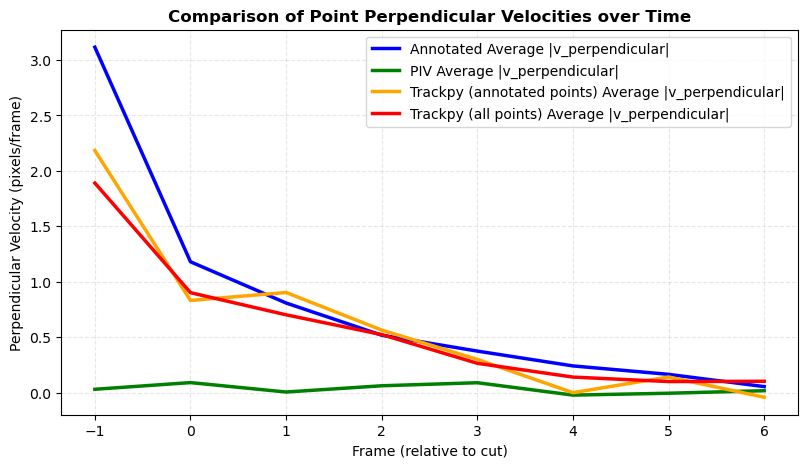

In [19]:
import benchmark.utils as bu

bu.compare_v_perpendicular_vs_time(
    (annotated_processed, 'Annotated', 'blue'),
    (piv_processed, 'PIV', 'green'),
    (trackpy_processed, 'Trackpy (annotated points)', 'orange'),
    (trackpy_all_processed, 'Trackpy (all points)', 'red'),
    end_offset=6,
    output_path='benchmark/plots/avg_velocity_comparison.png'
)

# Exponential Curve Fitting

In [22]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define exponential decay model: v(t) = A * exp(-t/tau) + C
def exponential_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

def fit_and_plot_exponential(*datasets, end_offset=8, apply_correction=True, n_bootstrap=1000, per_cell_type=False):
    """
    Fit exponential decay to mean absolute perpendicular velocity over time.
    Uses the already-calculated v_perpendicular_signed values.
    
    Parameters:
    -----------
    *datasets : tuple of (df, label, color)
        Variable number of datasets, each as a tuple of (dataframe, label, color)
    end_offset : int
        Maximum frame_rel to include in analysis
    apply_correction : bool
        If True, applies correction for velocity averaging bias (equation from Fig 3B)
    n_bootstrap : int
        Number of bootstrap iterations for error estimation
    per_cell_type : bool
        If True, fit each cell type separately within each dataset and create separate plots
    
    Returns:
    --------
    dict
        Dictionary mapping labels to fit results (or nested dict if per_cell_type=True)
    """
    results = {}
    
    if per_cell_type:
        # Collect all unique cell types across all datasets
        all_cell_types = set()
        for df, label, color in datasets:
            if 'cell_type' in df.columns:
                all_cell_types.update(df['cell_type'].dropna().unique())
        
        # Create a separate figure for each cell type
        for cell_type in sorted(all_cell_types):
            print(f"\n{'='*80}")
            print(f"PROCESSING CELL TYPE: {cell_type}")
            print(f"{'='*80}")
            
            plt.figure(figsize=(10, 6))
            
            # Process each dataset for this cell type
            for df, label, color in datasets:
                if 'cell_type' not in df.columns:
                    continue
                    
                df_filtered = df[df['cell_type'] == cell_type]
                
                if len(df_filtered) == 0:
                    print(f"\n{label}: No data for cell type {cell_type}")
                    continue
                
                print(f"\n{'='*60}")
                print(f"Fitting {label} - {cell_type}")
                print(f"{'='*60}")
                
                result = _fit_single_exponential(df_filtered, f"{label}", color, end_offset, apply_correction, n_bootstrap)
                
                if result is not None:
                    if label not in results:
                        results[label] = {}
                    results[label][cell_type] = result
            
            # Format the plot for this cell type
            plt.xlabel('Frame (relative to cut)', fontsize=12)
            plt.ylabel('v_perpendicular_signed (pixels/frame)', fontsize=12)
            plt.title(f'Exponential Decay Fit: {cell_type}', fontweight='bold', fontsize=14)
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.xticks(np.arange(-1, end_offset + 1, 1))
            plt.tight_layout()
            plt.show()
    else:
        # Single figure for all datasets combined
        plt.figure(figsize=(10, 6))
        
        for df, label, color in datasets:
            print(f"\n{'='*60}")
            print(f"Fitting {label}")
            print(f"{'='*60}")
            
            result = _fit_single_exponential(df, label, color, end_offset, apply_correction, n_bootstrap)
            if result is not None:
                results[label] = result
        
        # Format and show the combined plot
        plt.xlabel('Frame (relative to cut)', fontsize=12)
        plt.ylabel('v_perpendicular_signed (pixels/frame)', fontsize=12)
        plt.title('Exponential Decay Fit: Perpendicular Velocity vs Time', fontweight='bold', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xticks(np.arange(-1, end_offset + 1, 1))
        plt.tight_layout()
        plt.show()
    
    return results


def compare_fit_results(fit_results):
    """
    Compare exponential fit results across techniques and/or cell types.
    
    Parameters:
    -----------
    fit_results : dict
        Dictionary of fit results from fit_and_plot_exponential
        Can be flat (per_cell_type=False) or nested (per_cell_type=True)
    """
    if len(fit_results) < 2:
        print("Need at least 2 datasets to compare")
        return
    
    print(f"\n{'='*80}")
    print(f"COMPARISON ACROSS TECHNIQUES")
    print(f"{'='*80}")
    
    # Check if results are nested (per_cell_type=True)
    first_result = list(fit_results.values())[0]
    # If results contain 'vel' key directly, it's not nested (per_cell_type=False)
    is_nested = isinstance(first_result, dict) and 'vel' not in first_result
    
    if is_nested:
        # Results are organized by cell type
        # Collect all cell types
        all_cell_types = set()
        for label, cell_type_results in fit_results.items():
            all_cell_types.update(cell_type_results.keys())
        
        for cell_type in sorted(all_cell_types):
            print(f"\n{'='*80}")
            print(f"CELL TYPE: {cell_type}")
            print(f"{'='*80}")
            
            # Print comparison table for this cell type
            print(f"\n{'Technique':<30} {'vel':<20} {'rate':<20} {'tau':<20}")
            print(f"{'-'*80}")
            for label, cell_type_results in fit_results.items():
                if cell_type in cell_type_results:
                    result = cell_type_results[cell_type]
                    print(f"{label:<30} {result['vel']:.3f} ± {result['vel_err']:.3f}     "
                          f"{result['rate']:.3f} ± {result['rate_err']:.3f}     "
                          f"{result['tau']:.3f} ± {result['tau_err']:.3f}")
            
            # Pairwise ratios for this cell type
            labels_with_cell_type = [label for label, ct_results in fit_results.items() if cell_type in ct_results]
            if len(labels_with_cell_type) >= 2:
                print(f"\n{'Ratio':<40} {'vel':<15} {'rate':<15} {'tau':<15}")
                print(f"{'-'*80}")
                for i in range(len(labels_with_cell_type)):
                    for j in range(i+1, len(labels_with_cell_type)):
                        label1, label2 = labels_with_cell_type[i], labels_with_cell_type[j]
                        result1 = fit_results[label1][cell_type]
                        result2 = fit_results[label2][cell_type]
                        ratio_label = f"{label2}/{label1}"
                        vel_ratio = result2['vel'] / result1['vel']
                        rate_ratio = result2['rate'] / result1['rate']
                        tau_ratio = result2['tau'] / result1['tau']
                        print(f"{ratio_label:<40} {vel_ratio:.3f}          {rate_ratio:.3f}          {tau_ratio:.3f}")
    else:
        # Results are not nested (per_cell_type=False)
        # Print comparison table
        print(f"\n{'Technique':<30} {'vel':<20} {'rate':<20} {'tau':<20}")
        print(f"{'-'*80}")
        for label, result in fit_results.items():
            print(f"{label:<30} {result['vel']:.3f} ± {result['vel_err']:.3f}     "
                  f"{result['rate']:.3f} ± {result['rate_err']:.3f}     "
                  f"{result['tau']:.3f} ± {result['tau_err']:.3f}")
        
        # Pairwise ratios
        labels = list(fit_results.keys())
        if len(labels) >= 2:
            print(f"\n{'Ratio':<40} {'vel':<15} {'rate':<15} {'tau':<15}")
            print(f"{'-'*80}")
            for i in range(len(labels)):
                for j in range(i+1, len(labels)):
                    label1, label2 = labels[i], labels[j]
                    ratio_label = f"{label2}/{label1}"
                    vel_ratio = fit_results[label2]['vel'] / fit_results[label1]['vel']
                    rate_ratio = fit_results[label2]['rate'] / fit_results[label1]['rate']
                    tau_ratio = fit_results[label2]['tau'] / fit_results[label1]['tau']
                    print(f"{ratio_label:<40} {vel_ratio:.3f}          {rate_ratio:.3f}          {tau_ratio:.3f}")


def _fit_single_exponential(df, label, color, end_offset=8, apply_correction=True, n_bootstrap=1000):
    """
    Internal function to fit a single dataset.
    Updated to handle negative baselines and sanitize initial guesses.
    """
    # Filter data
    df_filtered = df.dropna(subset=['frame_rel', 'v_perpendicular_signed'])
    if end_offset is not None:
        df_filtered = df_filtered[df_filtered['frame_rel'] <= end_offset]
    
    # Calculate mean VELOCITY per frame_rel
    mean_velocity = df_filtered.groupby('frame_rel')['v_perpendicular_signed'].mean().sort_index()
    
    if len(mean_velocity) < 3:
        print(f"{label}: Not enough data points for fitting")
        return None
    
    # Prepare data for fitting
    t_data = mean_velocity.index.values
    v_data = mean_velocity.values
    
    # Start from frame_rel=-1 for fitting
    mask = t_data >= -1
    t_fit = t_data[mask]
    v_fit = v_data[mask]
    
    if len(t_fit) < 3:
        print(f"{label}: Not enough post-cut data points for fitting")
        return None
    
    # --- UPDATED BOUNDS & GUESSES ---
    
    # 1. Define Bounds
    # A: Must be positive (recoil magnitude)
    # tau: 0.1 to 20 (physics constraints)
    # C: Allow negative drift (changed from 0 to -100 to handle PIV noise)
    lower_bounds = [0, 0.1, -100]
    upper_bounds = [np.inf, 20, np.inf]
    bounds = (lower_bounds, upper_bounds)

    # 2. Calculate Initial Guesses
    # C guess: The last data point
    C_guess = v_fit[-1]
    
    # A guess: The drop from start to end
    A_guess = v_fit[0] - C_guess
    
    # tau guess: Standard start
    tau_guess = 2.0

    # 3. Sanitize Guesses (CRITICAL STEP)
    # Ensure guesses are strictly INSIDE bounds to prevent "Initial guess outside bounds" error
    # We add/subtract a tiny epsilon (1e-6) to ensure we aren't exactly on the edge
    
    # Clamp A (must be > 0)
    A_init = max(1e-6, A_guess)
    
    # Clamp tau (must be > 0.1)
    tau_init = max(0.11, min(19.9, tau_guess))
    
    # Clamp C (must be > -100)
    C_init = max(-99, C_guess)

    try:
        # --- 1. MAIN FIT ---
        popt, pcov = curve_fit(exponential_decay, t_fit, v_fit, 
                              p0=[A_init, tau_init, C_init],
                              bounds=bounds,
                              maxfev=10000)
        
        A_fit, tau_fit, C_fit = popt
        
        # Calculate Main Correction
        correction_factor = 1.0
        if apply_correction:
            correction_factor = 1.0 + (0.66 / tau_fit)
            
        A_corrected = A_fit * correction_factor
        vel_final = A_corrected + C_fit
        
        # --- 2. BOOTSTRAP FOR UNCERTAINTY ---
        print(f"  Running {n_bootstrap} bootstrap iterations...")
        
        bootstrap_params = []
        bootstrap_velocities = [] 
        
        df_for_bootstrap = df_filtered[['frame_rel', 'v_perpendicular_signed', 'cell_id']].copy()
        grouped = df_for_bootstrap.groupby('cell_id')
        cells = list(grouped.groups.keys())
        
        for i in range(n_bootstrap):
            # Resample cells with replacement
            resampled_cells = np.random.choice(cells, size=len(cells), replace=True)
            bootstrap_list = [grouped.get_group(cell) for cell in resampled_cells]
            bootstrap_df = pd.concat(bootstrap_list, ignore_index=True)
            
            bootstrap_mean = bootstrap_df.groupby('frame_rel')['v_perpendicular_signed'].mean().sort_index()
            
            b_t = bootstrap_mean.index.values
            b_v = bootstrap_mean.values
            b_mask = b_t >= -1
            b_t_fit = b_t[b_mask]
            b_v_fit = b_v[b_mask]
            
            if len(b_t_fit) < 3:
                continue
            
            try:
                # Fit bootstrap sample using the results of the main fit as the new guess
                # This is much more stable than recalculating guesses from scratch
                popt_boot, _ = curve_fit(exponential_decay, b_t_fit, b_v_fit,
                                        p0=popt, 
                                        bounds=bounds,
                                        maxfev=5000)
                
                b_A, b_tau, b_C = popt_boot
                
                b_factor = 1.0
                if apply_correction:
                    b_factor = 1.0 + (0.66 / b_tau)
                
                b_vel_corrected = (b_A * b_factor) + b_C
                
                bootstrap_params.append(popt_boot)
                bootstrap_velocities.append(b_vel_corrected)
                
            except Exception:
                continue
        
        # --- 3. STATS CALCULATION ---
        bootstrap_params = np.array(bootstrap_params)
        bootstrap_velocities = np.array(bootstrap_velocities)
        
        print(f"  Bootstrap completed: {len(bootstrap_params)} successful iterations")
        
        A_err = np.std(bootstrap_params[:, 0])
        tau_err = np.std(bootstrap_params[:, 1])
        C_err = np.std(bootstrap_params[:, 2])
        vel_err = np.std(bootstrap_velocities)
        
        rate = 1.0 / tau_fit
        rate_err = np.std(1.0 / bootstrap_params[:, 1])
        
        b_A_corrected_dist = bootstrap_params[:, 0] * (1.0 + (0.66 / bootstrap_params[:, 1])) if apply_correction else bootstrap_params[:, 0]
        A_corrected_err = np.std(b_A_corrected_dist)

        residuals = v_fit - exponential_decay(t_fit, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((v_fit - np.mean(v_fit))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # --- 4. PLOTTING ---
        t_smooth = np.linspace(t_fit[0], t_fit[-1], 100)
        v_smooth = exponential_decay(t_smooth, *popt)
        
        bootstrap_curves = []
        for params in bootstrap_params:
            bootstrap_curves.append(exponential_decay(t_smooth, *params))
        bootstrap_curves = np.array(bootstrap_curves)
        
        ci_lower = np.percentile(bootstrap_curves, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_curves, 97.5, axis=0)
        
        plt.plot(t_data, v_data, 'o', color=color, alpha=0.6, markersize=8, 
                label=f'{label} data')
        plt.plot(t_smooth, v_smooth, '-', color=color, linewidth=2.5, 
                label=f'{label} fit: τ={tau_fit:.2f}, R²={r_squared:.3f}')
        plt.fill_between(t_smooth, ci_lower, ci_upper, color=color, alpha=0.08, 
                        label=f'{label} 95% CI')
        
        print(f"\n{label} Exponential Fit Results:")
        print(f"  A (fitted) = {A_fit:.3f} ± {A_err:.3f} px/frame")
        if apply_correction:
            print(f"  Correction Factor (1 + 0.66/τ) = {correction_factor:.3f}")
            print(f"  A (corrected) = {A_corrected:.3f} ± {A_corrected_err:.3f} px/frame")
            print(f"  Initial Velocity (A_corr + C) = {vel_final:.3f} ± {vel_err:.3f} px/frame")
        else:
            print(f"  Initial Velocity (A + C) = {vel_final:.3f} ± {vel_err:.3f} px/frame")
            
        print(f"  τ (decay time) = {tau_fit:.3f} ± {tau_err:.3f} frames")
        print(f"  rate (1/τ) = {rate:.3f} ± {rate_err:.3f} frames⁻¹")
        print(f"  C (baseline) = {C_fit:.3f} ± {C_err:.3f} px/frame")
        print(f"  R² = {r_squared:.3f}")
        
        return {'A': A_fit, 'A_err': A_err, 
                'A_corrected': A_corrected, 'A_corrected_err': A_corrected_err,
                'vel': vel_final, 'vel_err': vel_err,
                'tau': tau_fit, 'tau_err': tau_err,
                'rate': rate, 'rate_err': rate_err,
                'C': C_fit, 'C_err': C_err,
                'R2': r_squared}
        
    except Exception as e:
        print(f"{label}: Fitting failed - {str(e)}")
        return None


Fitting Annotated
  Running 100 bootstrap iterations...
  Bootstrap completed: 100 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.160 ± 0.063 px/frame
  Initial Velocity (A + C) = 1.365 ± 0.058 px/frame
  τ (decay time) = 1.104 ± 0.062 frames
  rate (1/τ) = 0.905 ± 0.050 frames⁻¹
  C (baseline) = 0.205 ± 0.022 px/frame
  R² = 0.985

Fitting PIV
  Running 100 bootstrap iterations...
  Bootstrap completed: 100 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.164 ± 0.131 px/frame
  Initial Velocity (A + C) = 0.051 ± 0.024 px/frame
  τ (decay time) = 20.000 ± 6.581 frames
  rate (1/τ) = 0.050 ± 0.958 frames⁻¹
  C (baseline) = -0.113 ± 0.121 px/frame
  R² = 0.173

Fitting Trackpy (annotated points)
  Running 100 bootstrap iterations...
  Bootstrap completed: 100 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 1.192 ± 0.418 px/frame
  Initial Velocity (A + C) = 1.198 ± 0.125 px/frame
  τ (decay time) =

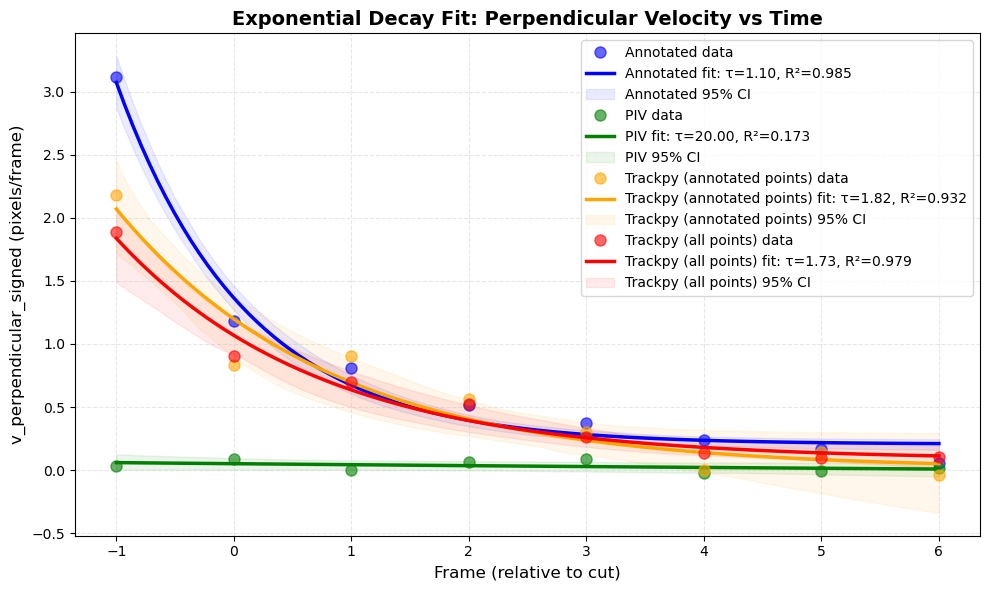

In [29]:
# Fit and plot all datasets
# When per_cell_type=True, separate figures will be created for each cell type

fit_results_all = fit_and_plot_exponential(
    (annotated_processed, 'Annotated', 'blue'),
    (piv_processed, 'PIV', 'green'),
    (trackpy_processed, 'Trackpy (annotated points)', 'orange'),
    (trackpy_all_processed, 'Trackpy (all points)', 'red'),
    end_offset=6,
    apply_correction=False, 
    n_bootstrap=100,
    per_cell_type=False
)

In [30]:
# Compare results
compare_fit_results(fit_results_all)


COMPARISON ACROSS TECHNIQUES

Technique                      vel                  rate                 tau                 
--------------------------------------------------------------------------------
Annotated                      1.365 ± 0.058     0.905 ± 0.050     1.104 ± 0.062
PIV                            0.051 ± 0.024     0.050 ± 0.958     20.000 ± 6.581
Trackpy (annotated points)     1.198 ± 0.125     0.549 ± 0.222     1.822 ± 0.994
Trackpy (all points)           1.068 ± 0.078     0.577 ± 0.119     1.734 ± 0.399

Ratio                                    vel             rate            tau            
--------------------------------------------------------------------------------
PIV/Annotated                            0.037          0.055          18.109
Trackpy (annotated points)/Annotated     0.878          0.606          1.650
Trackpy (all points)/Annotated           0.783          0.637          1.570
Trackpy (annotated points)/PIV           23.618          10.975   

# Per cell type


PROCESSING CELL TYPE: AB

Fitting Annotated - AB
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.266 ± 0.118 px/frame
  Initial Velocity (A + C) = 1.458 ± 0.105 px/frame
  τ (decay time) = 0.938 ± 0.140 frames
  rate (1/τ) = 1.066 ± 0.141 frames⁻¹
  C (baseline) = 0.192 ± 0.048 px/frame
  R² = 0.984

Fitting PIV - AB
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.283 ± 0.437 px/frame
  Initial Velocity (A + C) = 0.154 ± 0.126 px/frame
  τ (decay time) = 15.303 ± 8.594 frames
  rate (1/τ) = 0.065 ± 0.323 frames⁻¹
  C (baseline) = -0.129 ± 0.376 px/frame
  R² = 0.128

Fitting Trackpy (annotated points) - AB
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 1.616 ± 4.007 px/frame
  Initial Velocity (A + C) = 1.283 

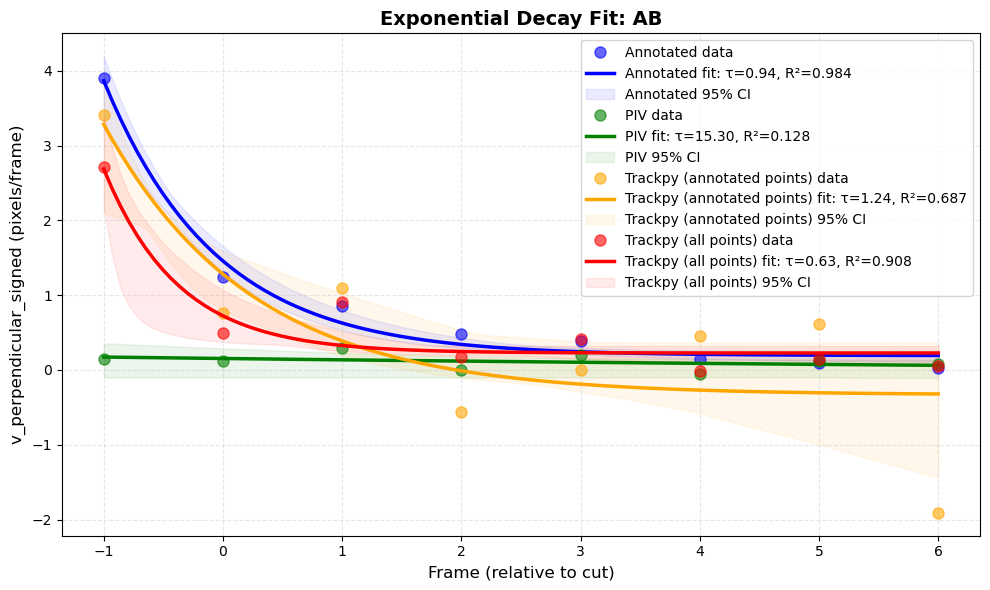


PROCESSING CELL TYPE: ABal

Fitting Annotated - ABal
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.110 ± 0.105 px/frame
  Initial Velocity (A + C) = 1.288 ± 0.078 px/frame
  τ (decay time) = 1.218 ± 0.390 frames
  rate (1/τ) = 0.821 ± 0.223 frames⁻¹
  C (baseline) = 0.178 ± 0.062 px/frame
  R² = 0.983

Fitting PIV - ABal
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.281 px/frame
  Initial Velocity (A + C) = 0.002 ± 0.142 px/frame
  τ (decay time) = 19.996 ± 5.966 frames
  rate (1/τ) = 0.050 ± 2.710 frames⁻¹
  C (baseline) = 0.002 ± 0.300 px/frame
  R² = -0.000

Fitting Trackpy (annotated points) - ABal
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 1.228 ± 0.538 px/frame
  Initial Velocity (A + C) 

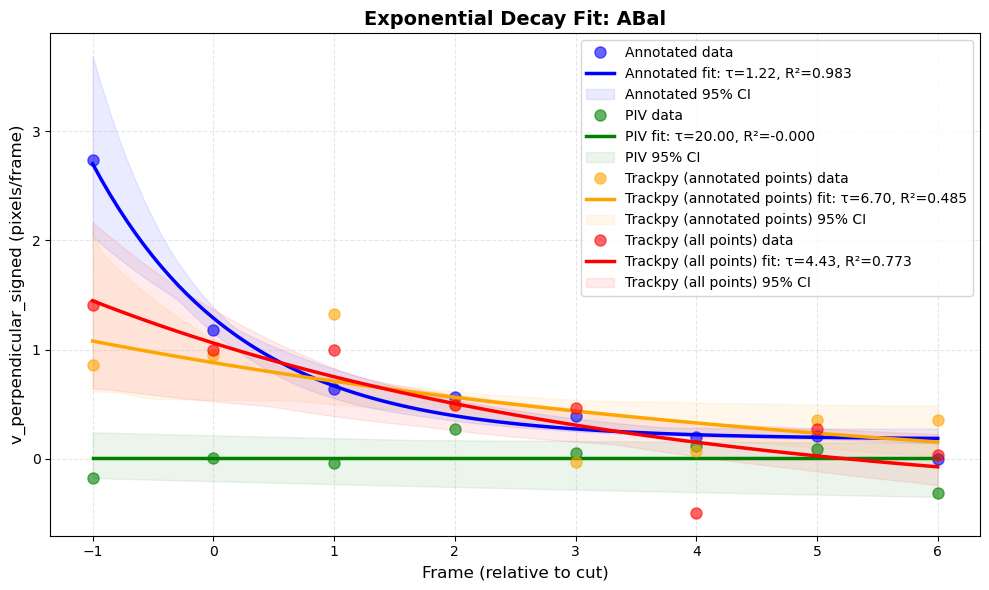


PROCESSING CELL TYPE: ABal_

Fitting Annotated - ABal_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 7.258 ± 0.000 px/frame
  Initial Velocity (A + C) = 2.321 ± 0.000 px/frame
  τ (decay time) = 20.000 ± 0.000 frames
  rate (1/τ) = 0.050 ± 0.000 frames⁻¹
  C (baseline) = -4.937 ± 0.000 px/frame
  R² = 0.576

Fitting PIV - ABal_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.000 px/frame
  Initial Velocity (A + C) = 0.137 ± 0.000 px/frame
  τ (decay time) = 4.981 ± 0.000 frames
  rate (1/τ) = 0.201 ± 0.000 frames⁻¹
  C (baseline) = 0.137 ± 0.000 px/frame
  R² = 0.000

Fitting Trackpy (annotated points) - ABal_
Trackpy (annotated points): Not enough data points for fitting

Fitting Trackpy (all points) - ABal_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (all

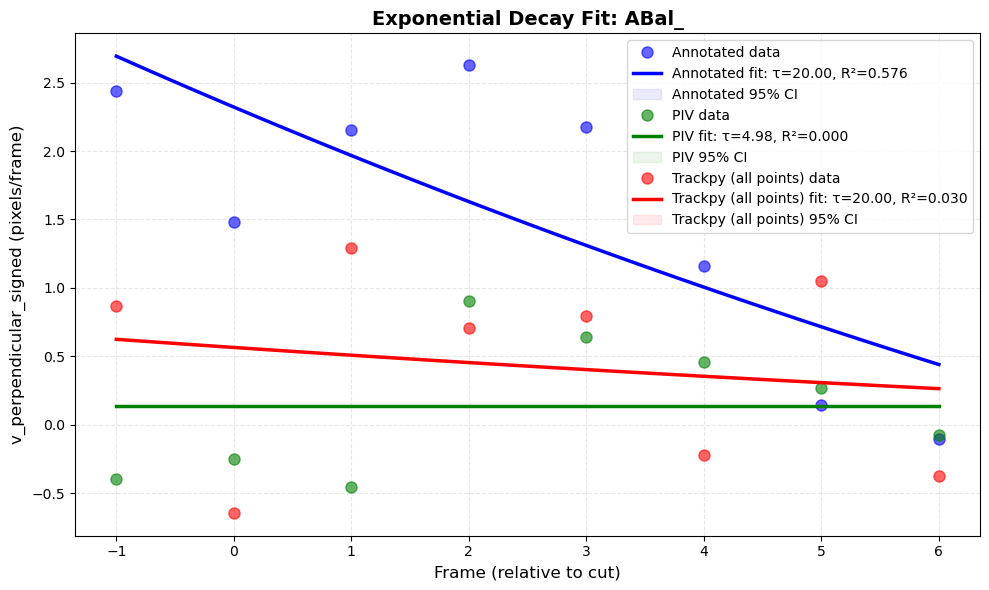


PROCESSING CELL TYPE: ABar

Fitting Annotated - ABar
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.932 ± 0.166 px/frame
  Initial Velocity (A + C) = 1.313 ± 0.131 px/frame
  τ (decay time) = 1.005 ± 0.144 frames
  rate (1/τ) = 0.995 ± 0.151 frames⁻¹
  C (baseline) = 0.381 ± 0.083 px/frame
  R² = 0.975

Fitting PIV - ABar
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.781 ± 0.606 px/frame
  Initial Velocity (A + C) = -0.012 ± 0.137 px/frame
  τ (decay time) = 20.000 ± 5.516 frames
  rate (1/τ) = 0.050 ± 0.182 frames⁻¹
  C (baseline) = -0.793 ± 0.524 px/frame
  R² = 0.196

Fitting Trackpy (annotated points) - ABar
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 0.761 ± 1.848 px/frame
  Initial Velocity (A + C)

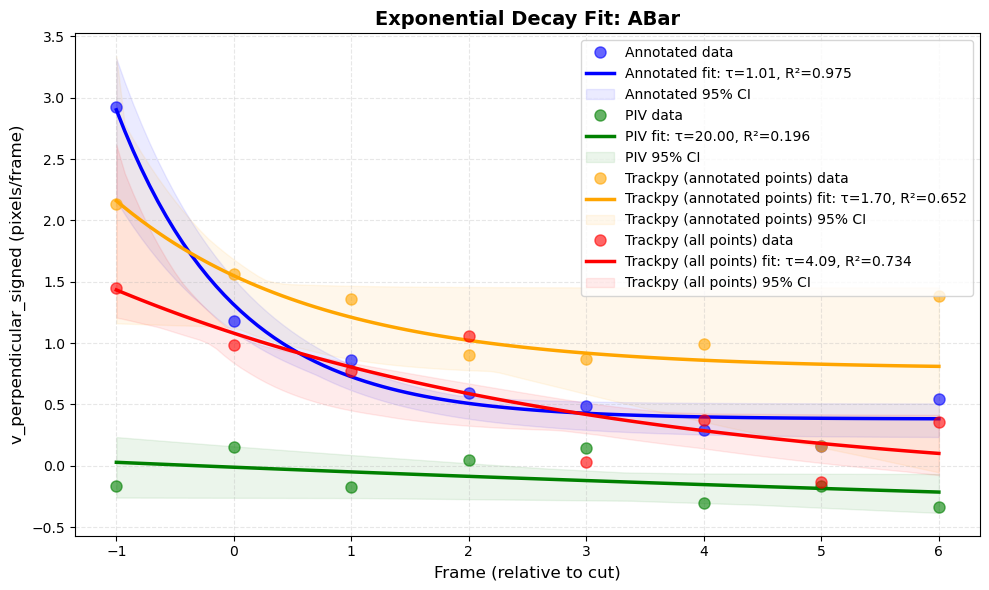


PROCESSING CELL TYPE: ABar_

Fitting Annotated - ABar_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.825 ± 0.185 px/frame
  Initial Velocity (A + C) = 1.106 ± 0.212 px/frame
  τ (decay time) = 1.134 ± 0.272 frames
  rate (1/τ) = 0.882 ± 0.224 frames⁻¹
  C (baseline) = 0.281 ± 0.169 px/frame
  R² = 0.980

Fitting PIV - ABar_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.009 ± 0.090 px/frame
  Initial Velocity (A + C) = 0.019 ± 0.089 px/frame
  τ (decay time) = 1.373 ± 3.548 frames
  rate (1/τ) = 0.728 ± 0.226 frames⁻¹
  C (baseline) = 0.009 ± 0.093 px/frame
  R² = 0.001

Fitting Trackpy (annotated points) - ABar_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 0.000 ± 0.000 px/frame
  Initial Velocity (A + C

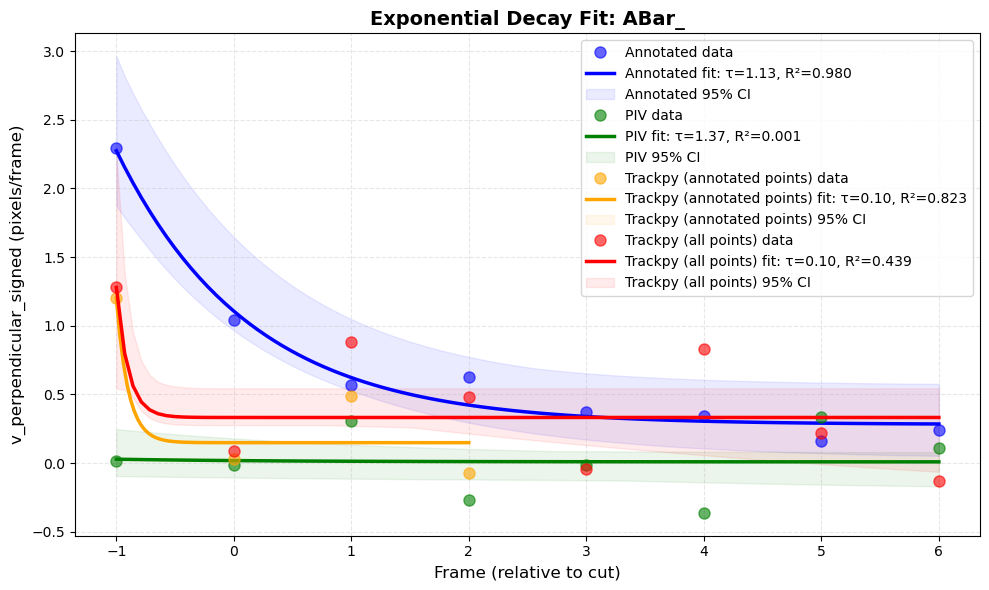


PROCESSING CELL TYPE: ABpl

Fitting Annotated - ABpl
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.220 ± 0.142 px/frame
  Initial Velocity (A + C) = 1.601 ± 0.184 px/frame
  τ (decay time) = 0.978 ± 0.144 frames
  rate (1/τ) = 1.023 ± 0.157 frames⁻¹
  C (baseline) = 0.381 ± 0.073 px/frame
  R² = 0.991

Fitting PIV - ABpl
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.251 ± 0.491 px/frame
  Initial Velocity (A + C) = 0.152 ± 0.105 px/frame
  τ (decay time) = 10.246 ± 8.716 frames
  rate (1/τ) = 0.098 ± 0.239 frames⁻¹
  C (baseline) = -0.098 ± 0.445 px/frame
  R² = 0.124

Fitting Trackpy (annotated points) - ABpl
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 1.115 ± 0.787 px/frame
  Initial Velocity (A + C) 

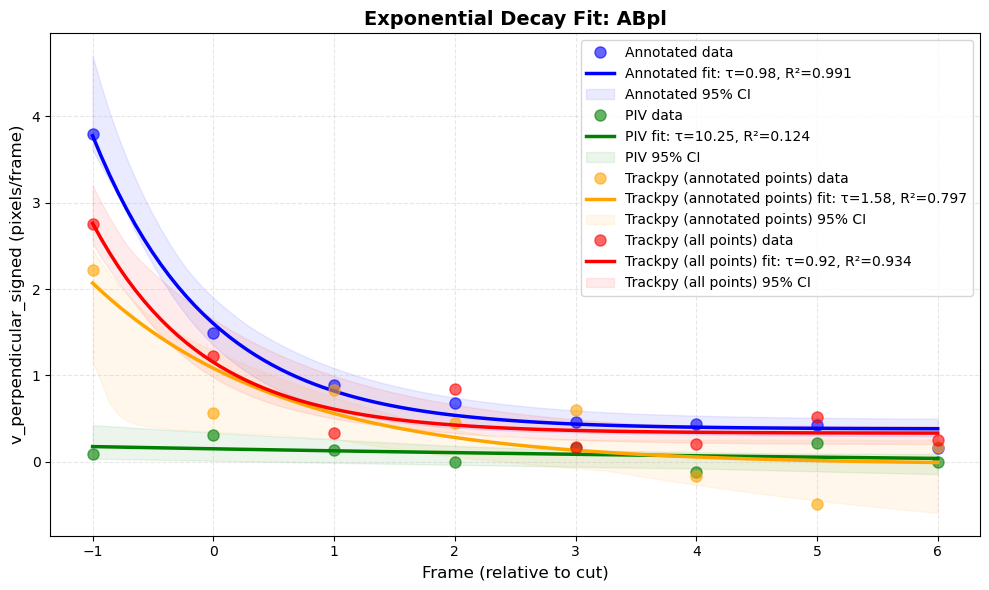


PROCESSING CELL TYPE: ABpl_

Fitting Annotated - ABpl_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.604 ± 0.141 px/frame
  Initial Velocity (A + C) = 0.810 ± 0.173 px/frame
  τ (decay time) = 0.858 ± 0.105 frames
  rate (1/τ) = 1.166 ± 0.175 frames⁻¹
  C (baseline) = 0.206 ± 0.042 px/frame
  R² = 0.994

Fitting PIV - ABpl_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.576 ± 0.520 px/frame
  Initial Velocity (A + C) = 0.010 ± 0.076 px/frame
  τ (decay time) = 20.000 ± 7.611 frames
  rate (1/τ) = 0.050 ± 2.972 frames⁻¹
  C (baseline) = -0.566 ± 0.487 px/frame
  R² = 0.081

Fitting Trackpy (annotated points) - ABpl_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 0.000 ± 5.242 px/frame
  Initial Velocity (A +

/tmp/ipykernel_40116/819466422.py:302: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_boot, _ = curve_fit(exponential_decay, b_t_fit, b_v_fit,


  Bootstrap completed: 10 successful iterations

Trackpy (all points) Exponential Fit Results:
  A (fitted) = 0.219 ± 0.228 px/frame
  Initial Velocity (A + C) = 0.185 ± 0.163 px/frame
  τ (decay time) = 0.807 ± 5.757 frames
  rate (1/τ) = 1.240 ± 3.656 frames⁻¹
  C (baseline) = -0.034 ± 0.229 px/frame
  R² = 0.435


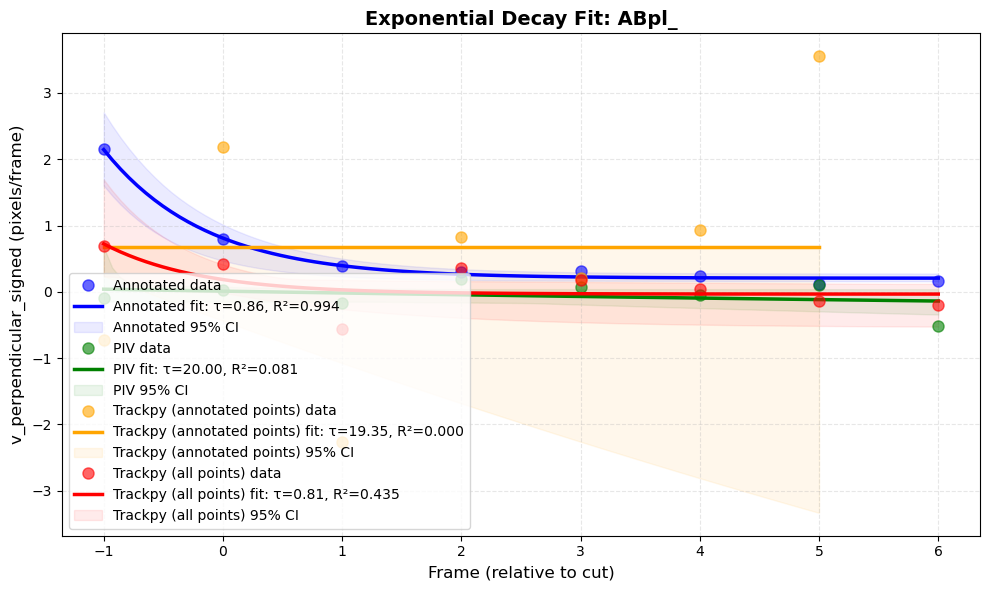


PROCESSING CELL TYPE: ABpr

Fitting Annotated - ABpr
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.981 ± 0.176 px/frame
  Initial Velocity (A + C) = 1.243 ± 0.103 px/frame
  τ (decay time) = 1.316 ± 0.401 frames
  rate (1/τ) = 0.760 ± 0.203 frames⁻¹
  C (baseline) = 0.262 ± 0.112 px/frame
  R² = 0.964

Fitting PIV - ABpr
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.388 px/frame
  Initial Velocity (A + C) = 0.008 ± 0.051 px/frame
  τ (decay time) = 18.168 ± 6.842 frames
  rate (1/τ) = 0.055 ± 0.156 frames⁻¹
  C (baseline) = 0.008 ± 0.353 px/frame
  R² = -0.000

Fitting Trackpy (annotated points) - ABpr
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 0.000 ± 0.000 px/frame
  Initial Velocity (A + C) 

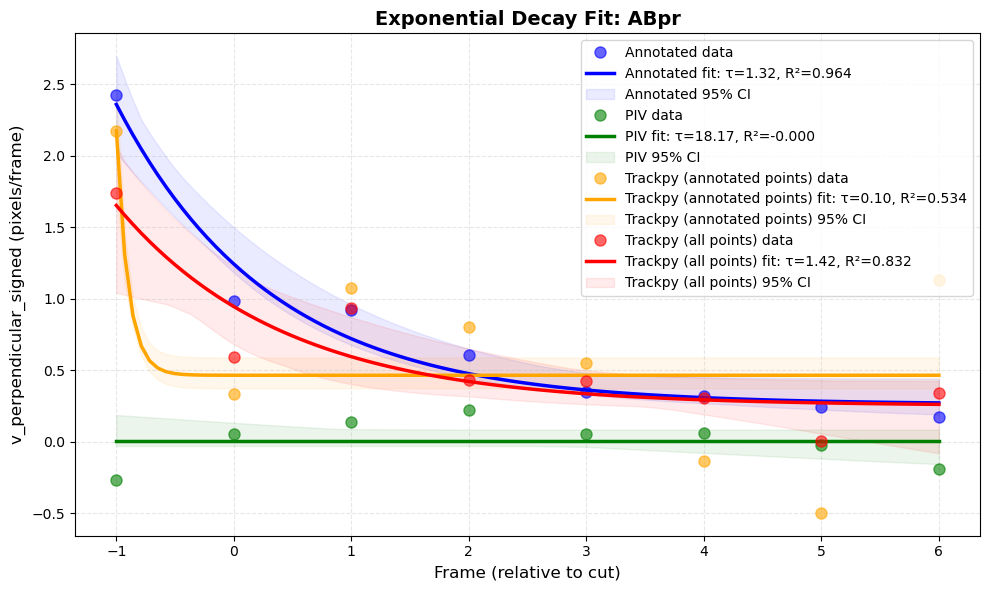


PROCESSING CELL TYPE: ABpr_

Fitting Annotated - ABpr_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.763 ± 0.223 px/frame
  Initial Velocity (A + C) = 0.799 ± 0.227 px/frame
  τ (decay time) = 0.981 ± 0.101 frames
  rate (1/τ) = 1.019 ± 0.107 frames⁻¹
  C (baseline) = 0.036 ± 0.036 px/frame
  R² = 0.990

Fitting PIV - ABpr_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.098 ± 0.140 px/frame
  Initial Velocity (A + C) = 0.030 ± 0.066 px/frame
  τ (decay time) = 1.005 ± 8.616 frames
  rate (1/τ) = 0.995 ± 1.239 frames⁻¹
  C (baseline) = -0.068 ± 0.098 px/frame
  R² = 0.494

Fitting Trackpy (annotated points) - ABpr_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 0.000 ± 0.000 px/frame
  Initial Velocity (A + 

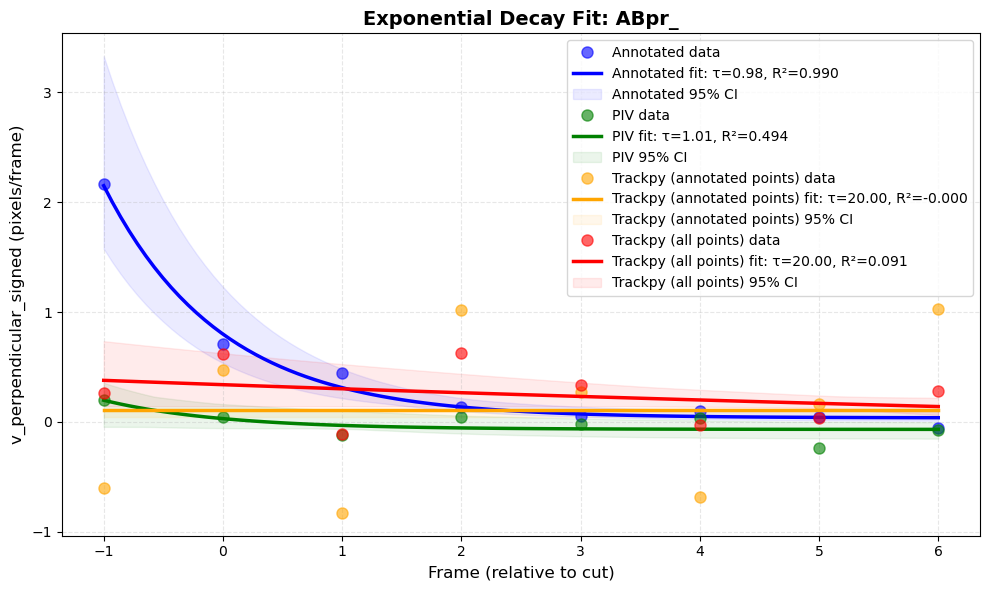


PROCESSING CELL TYPE: C

Fitting Annotated - C
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.899 ± 0.000 px/frame
  Initial Velocity (A + C) = 1.586 ± 0.000 px/frame
  τ (decay time) = 0.601 ± 0.000 frames
  rate (1/τ) = 1.663 ± 0.000 frames⁻¹
  C (baseline) = 0.687 ± 0.000 px/frame
  R² = 0.954

Fitting PIV - C
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.286 ± 0.000 px/frame
  Initial Velocity (A + C) = 0.425 ± 0.000 px/frame
  τ (decay time) = 1.053 ± 0.000 frames
  rate (1/τ) = 0.950 ± 0.000 frames⁻¹
  C (baseline) = 0.139 ± 0.000 px/frame
  R² = 0.102

Fitting Trackpy (annotated points) - C
Trackpy (annotated points): Not enough data points for fitting

Trackpy (all points): No data for cell type C


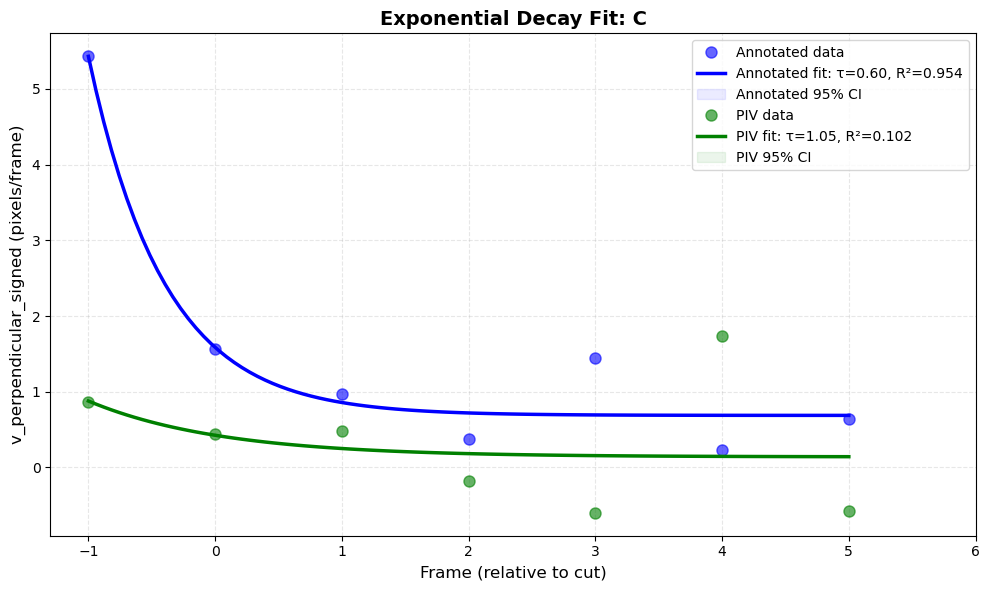


PROCESSING CELL TYPE: E

Fitting Annotated - E
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.939 ± 0.138 px/frame
  Initial Velocity (A + C) = 1.153 ± 0.118 px/frame
  τ (decay time) = 0.932 ± 0.154 frames
  rate (1/τ) = 1.073 ± 0.179 frames⁻¹
  C (baseline) = 0.214 ± 0.060 px/frame
  R² = 0.994

Fitting PIV - E
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.014 px/frame
  Initial Velocity (A + C) = 0.113 ± 0.061 px/frame
  τ (decay time) = 18.772 ± 5.792 frames
  rate (1/τ) = 0.053 ± 0.489 frames⁻¹
  C (baseline) = 0.113 ± 0.072 px/frame
  R² = -0.000

Fitting Trackpy (annotated points) - E
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 1.709 ± 1.591 px/frame
  Initial Velocity (A + C) = 0.889 ± 0.

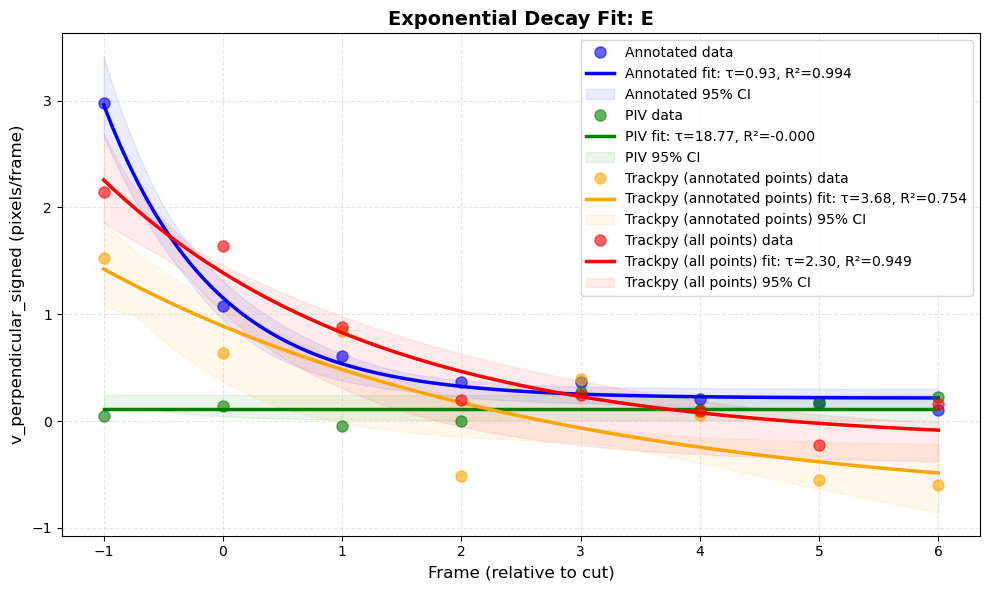


PROCESSING CELL TYPE: EMS

Fitting Annotated - EMS
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.148 ± 0.000 px/frame
  Initial Velocity (A + C) = 1.575 ± 0.000 px/frame
  τ (decay time) = 0.679 ± 0.000 frames
  rate (1/τ) = 1.474 ± 0.000 frames⁻¹
  C (baseline) = 0.427 ± 0.000 px/frame
  R² = 0.974

Fitting PIV - EMS
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.546 ± 0.000 px/frame
  Initial Velocity (A + C) = 0.385 ± 0.000 px/frame
  τ (decay time) = 1.435 ± 0.000 frames
  rate (1/τ) = 0.697 ± 0.000 frames⁻¹
  C (baseline) = -0.161 ± 0.000 px/frame
  R² = 0.826

Fitting Trackpy (annotated points) - EMS
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 1.465 ± 0.000 px/frame
  Initial Velocity (A + C) = 0.6

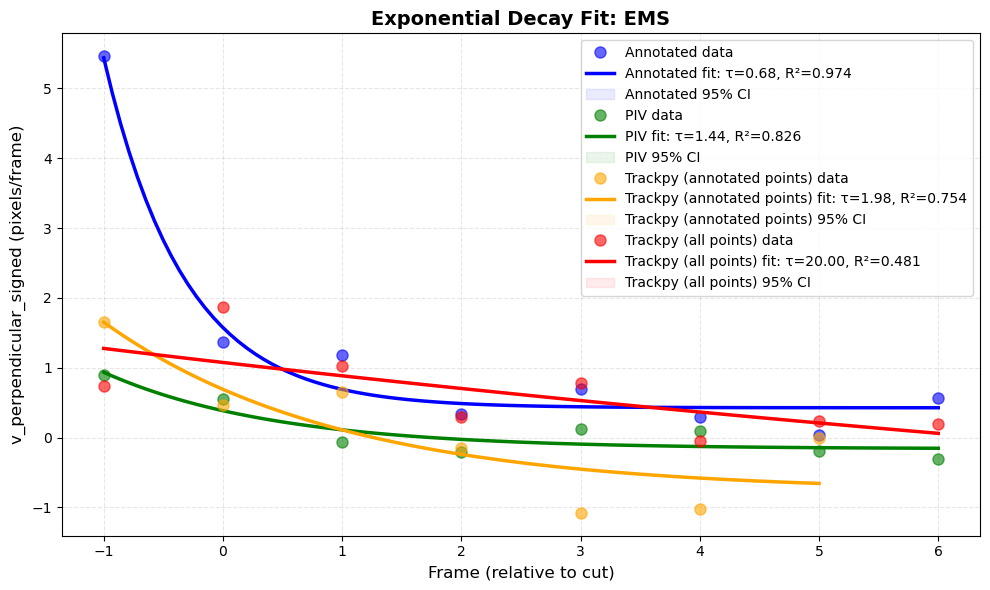


PROCESSING CELL TYPE: E_

Fitting Annotated - E_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.559 ± 0.499 px/frame
  Initial Velocity (A + C) = 1.718 ± 0.320 px/frame
  τ (decay time) = 1.090 ± 0.554 frames
  rate (1/τ) = 0.918 ± 0.268 frames⁻¹
  C (baseline) = 0.158 ± 0.186 px/frame
  R² = 0.988

Fitting PIV - E_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.352 ± 0.326 px/frame
  Initial Velocity (A + C) = 0.270 ± 0.181 px/frame
  τ (decay time) = 20.000 ± 2.520 frames
  rate (1/τ) = 0.050 ± 0.009 frames⁻¹
  C (baseline) = -0.082 ± 0.249 px/frame
  R² = 0.030

Fitting Trackpy (annotated points) - E_
Trackpy (annotated points): Not enough data points for fitting

Fitting Trackpy (all points) - E_
  Running 10 bootstrap iterations...
  Bootstrap completed: 8 successful iterations

Trackpy (all points) Exponen

/tmp/ipykernel_40116/819466422.py:302: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_boot, _ = curve_fit(exponential_decay, b_t_fit, b_v_fit,


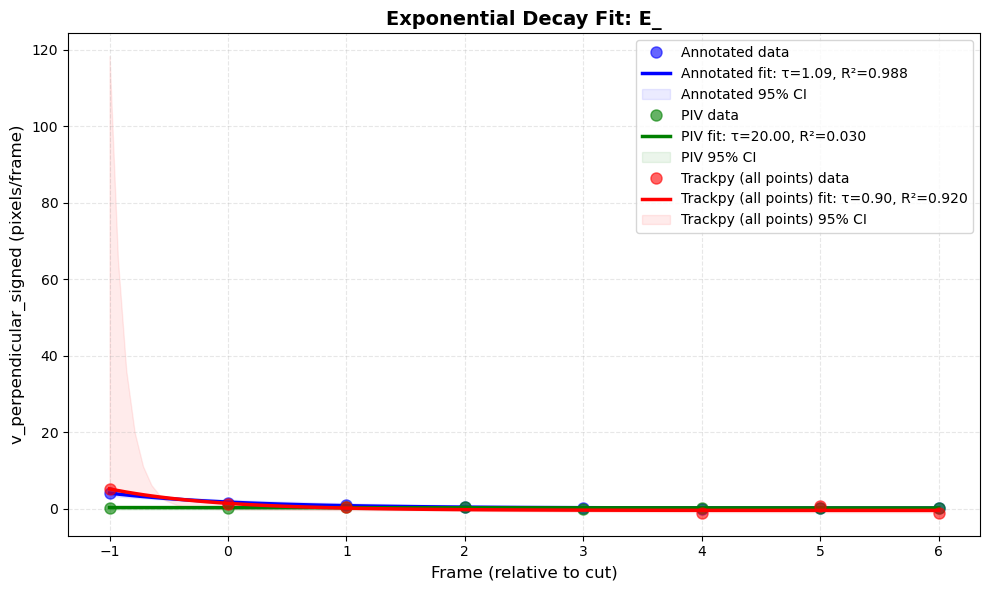


PROCESSING CELL TYPE: MS

Fitting Annotated - MS
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.443 ± 0.248 px/frame
  Initial Velocity (A + C) = 1.277 ± 0.150 px/frame
  τ (decay time) = 2.034 ± 0.445 frames
  rate (1/τ) = 0.492 ± 0.165 frames⁻¹
  C (baseline) = -0.166 ± 0.113 px/frame
  R² = 0.980

Fitting PIV - MS
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.004 px/frame
  Initial Velocity (A + C) = 0.004 ± 0.039 px/frame
  τ (decay time) = 14.369 ± 6.838 frames
  rate (1/τ) = 0.070 ± 2.909 frames⁻¹
  C (baseline) = 0.004 ± 0.040 px/frame
  R² = -0.000

Fitting Trackpy (annotated points) - MS
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 10.139 ± 3.102 px/frame
  Initial Velocity (A + C) = 1.28

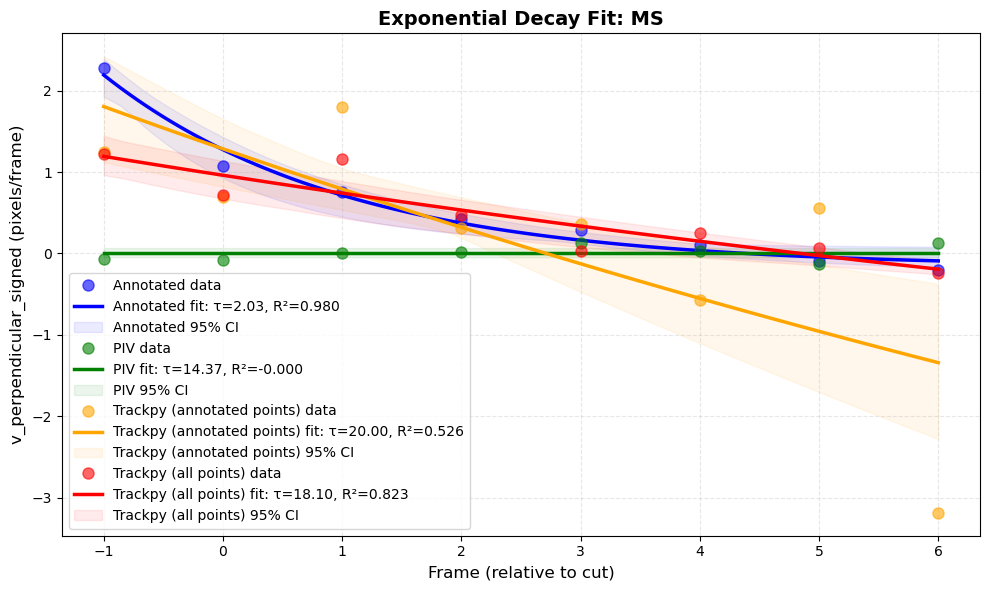


PROCESSING CELL TYPE: MS_

Fitting Annotated - MS_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.956 ± 0.087 px/frame
  Initial Velocity (A + C) = 1.092 ± 0.076 px/frame
  τ (decay time) = 1.132 ± 0.105 frames
  rate (1/τ) = 0.884 ± 0.093 frames⁻¹
  C (baseline) = 0.136 ± 0.097 px/frame
  R² = 0.995

Fitting PIV - MS_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.048 px/frame
  Initial Velocity (A + C) = 0.042 ± 0.124 px/frame
  τ (decay time) = 10.482 ± 6.153 frames
  rate (1/τ) = 0.095 ± 1.463 frames⁻¹
  C (baseline) = 0.042 ± 0.087 px/frame
  R² = 0.000

Fitting Trackpy (annotated points) - MS_
  Running 10 bootstrap iterations...


/tmp/ipykernel_40116/819466422.py:302: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_boot, _ = curve_fit(exponential_decay, b_t_fit, b_v_fit,


  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 0.541 ± 3.141 px/frame
  Initial Velocity (A + C) = 1.033 ± 0.333 px/frame
  τ (decay time) = 0.705 ± 9.468 frames
  rate (1/τ) = 1.418 ± 0.727 frames⁻¹
  C (baseline) = 0.492 ± 2.853 px/frame
  R² = 0.577

Fitting Trackpy (all points) - MS_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (all points) Exponential Fit Results:
  A (fitted) = 0.677 ± 0.150 px/frame
  Initial Velocity (A + C) = 0.719 ± 0.119 px/frame
  τ (decay time) = 0.780 ± 0.137 frames
  rate (1/τ) = 1.281 ± 0.203 frames⁻¹
  C (baseline) = 0.042 ± 0.130 px/frame
  R² = 0.759


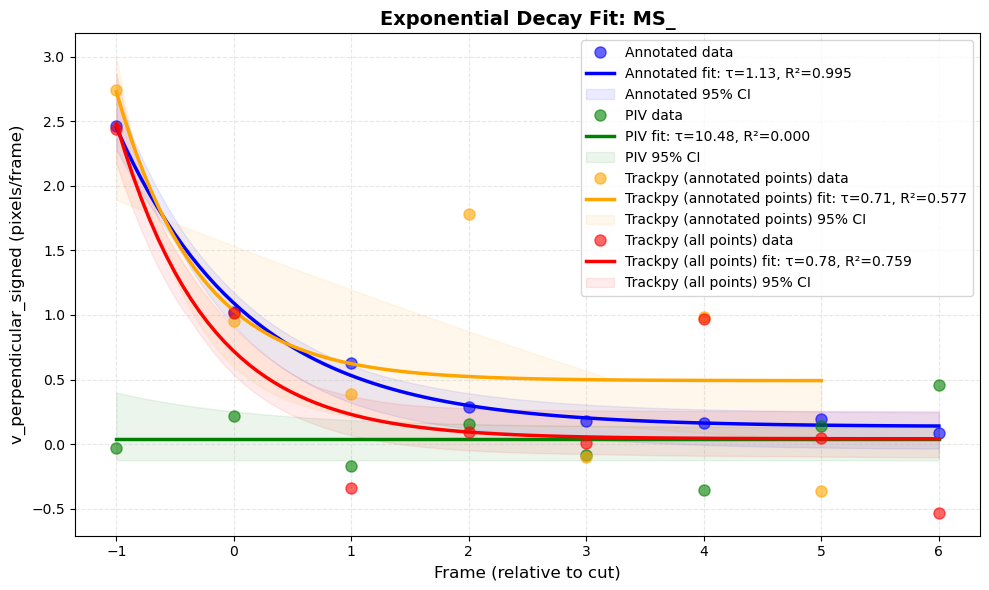


PROCESSING CELL TYPE: P0-A

Fitting Annotated - P0-A
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.842 ± 0.243 px/frame
  Initial Velocity (A + C) = 2.032 ± 0.256 px/frame
  τ (decay time) = 1.222 ± 0.110 frames
  rate (1/τ) = 0.818 ± 0.079 frames⁻¹
  C (baseline) = 0.190 ± 0.030 px/frame
  R² = 0.985

Fitting PIV - P0-A
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.031 ± 0.264 px/frame
  Initial Velocity (A + C) = 0.002 ± 0.118 px/frame
  τ (decay time) = 0.373 ± 3.642 frames
  rate (1/τ) = 2.680 ± 4.261 frames⁻¹
  C (baseline) = -0.029 ± 0.177 px/frame
  R² = 0.949

Fitting Trackpy (annotated points) - P0-A
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 1.331 ± 0.423 px/frame
  Initial Velocity (A + C) =

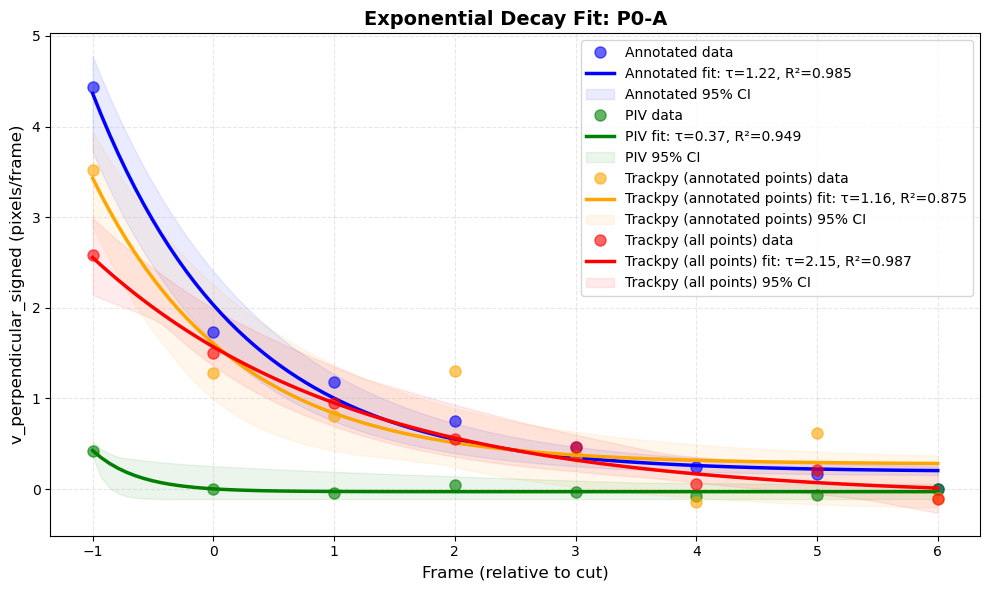


PROCESSING CELL TYPE: P0-P

Fitting Annotated - P0-P
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.699 ± 0.080 px/frame
  Initial Velocity (A + C) = 0.982 ± 0.098 px/frame
  τ (decay time) = 0.779 ± 0.111 frames
  rate (1/τ) = 1.284 ± 0.200 frames⁻¹
  C (baseline) = 0.283 ± 0.043 px/frame
  R² = 0.961

Fitting PIV - P0-P
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.019 px/frame
  Initial Velocity (A + C) = 0.019 ± 0.049 px/frame
  τ (decay time) = 1.641 ± 0.594 frames
  rate (1/τ) = 0.609 ± 2.791 frames⁻¹
  C (baseline) = 0.019 ± 0.051 px/frame
  R² = 0.000

Fitting Trackpy (annotated points) - P0-P
Trackpy (annotated points): Not enough data points for fitting

Fitting Trackpy (all points) - P0-P
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (all points

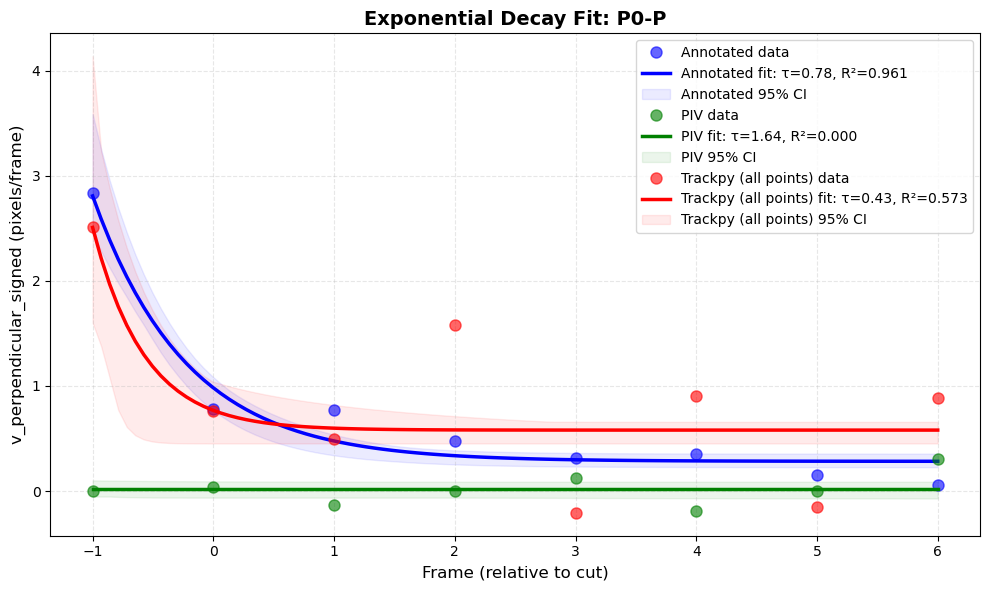


PROCESSING CELL TYPE: P1

Fitting Annotated - P1
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.676 ± 0.646 px/frame
  Initial Velocity (A + C) = 1.730 ± 0.668 px/frame
  τ (decay time) = 1.257 ± 0.370 frames
  rate (1/τ) = 0.795 ± 0.352 frames⁻¹
  C (baseline) = 0.055 ± 0.055 px/frame
  R² = 0.974

Fitting PIV - P1
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 1.226 ± 0.556 px/frame
  Initial Velocity (A + C) = 0.257 ± 0.100 px/frame
  τ (decay time) = 12.811 ± 8.023 frames
  rate (1/τ) = 0.078 ± 0.194 frames⁻¹
  C (baseline) = -0.969 ± 0.525 px/frame
  R² = 0.464

Fitting Trackpy (annotated points) - P1
Trackpy (annotated points): Not enough data points for fitting

Fitting Trackpy (all points) - P1
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (all points) Expone

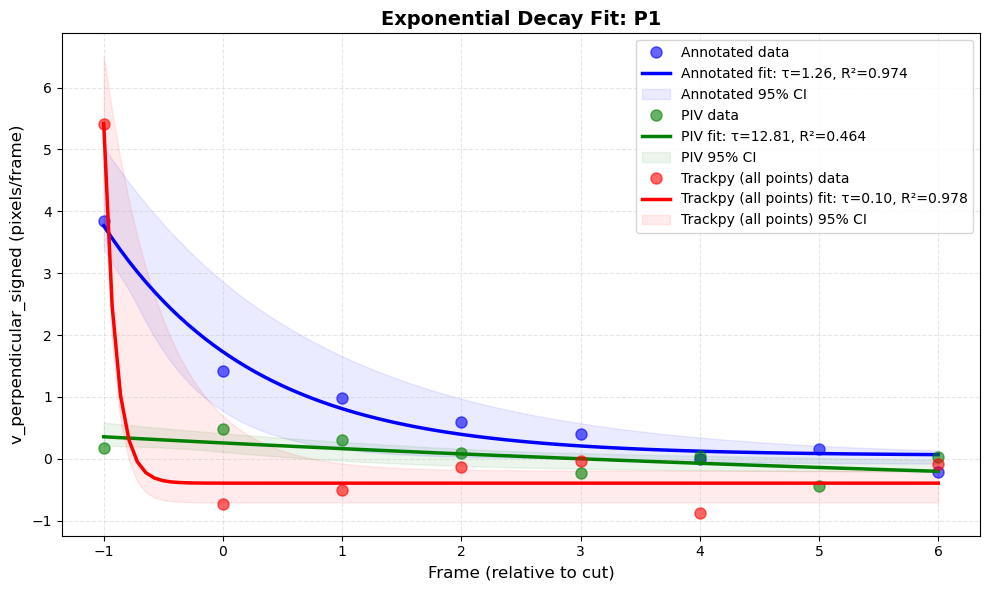


PROCESSING CELL TYPE: P2

Fitting Annotated - P2
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 0.752 ± 0.174 px/frame
  Initial Velocity (A + C) = 0.879 ± 0.197 px/frame
  τ (decay time) = 0.818 ± 0.132 frames
  rate (1/τ) = 1.222 ± 0.166 frames⁻¹
  C (baseline) = 0.127 ± 0.054 px/frame
  R² = 0.980

Fitting PIV - P2
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.000 ± 0.171 px/frame
  Initial Velocity (A + C) = -0.120 ± 0.050 px/frame
  τ (decay time) = 18.811 ± 7.052 frames
  rate (1/τ) = 0.053 ± 2.906 frames⁻¹
  C (baseline) = -0.120 ± 0.212 px/frame
  R² = -0.000

Fitting Trackpy (annotated points) - P2
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (annotated points) Exponential Fit Results:
  A (fitted) = 0.000 ± 0.163 px/frame
  Initial Velocity (A + C) = 0.35

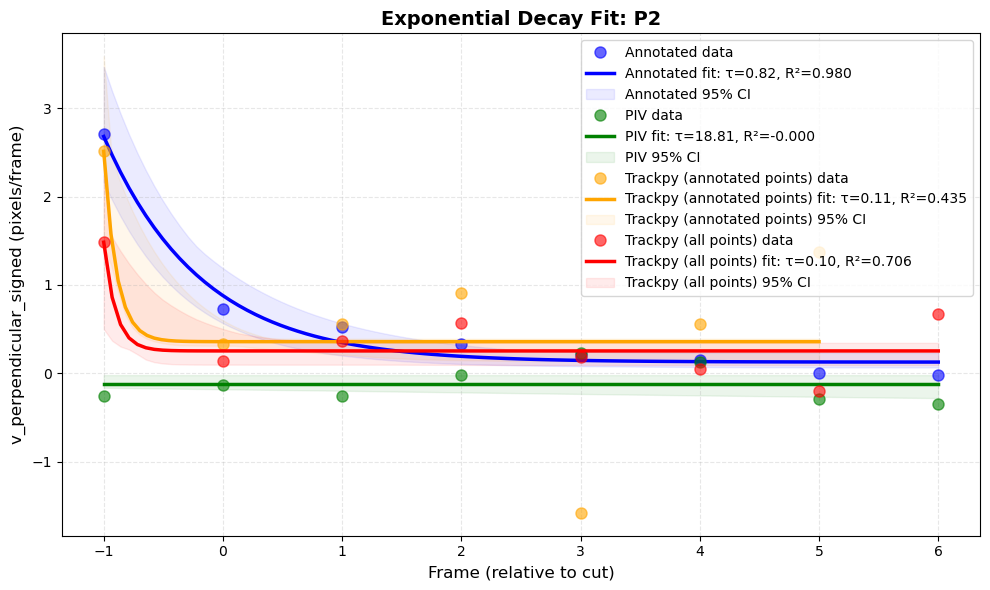


PROCESSING CELL TYPE: P2_

Fitting Annotated - P2_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Annotated Exponential Fit Results:
  A (fitted) = 1.090 ± 0.144 px/frame
  Initial Velocity (A + C) = 1.297 ± 0.246 px/frame
  τ (decay time) = 1.046 ± 0.087 frames
  rate (1/τ) = 0.956 ± 0.079 frames⁻¹
  C (baseline) = 0.207 ± 0.108 px/frame
  R² = 0.992

Fitting PIV - P2_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

PIV Exponential Fit Results:
  A (fitted) = 0.883 ± 0.847 px/frame
  Initial Velocity (A + C) = 0.026 ± 0.312 px/frame
  τ (decay time) = 20.000 ± 9.280 frames
  rate (1/τ) = 0.050 ± 3.822 frames⁻¹
  C (baseline) = -0.857 ± 0.592 px/frame
  R² = 0.447

Fitting Trackpy (annotated points) - P2_
Trackpy (annotated points): Not enough data points for fitting

Fitting Trackpy (all points) - P2_
  Running 10 bootstrap iterations...
  Bootstrap completed: 10 successful iterations

Trackpy (all points) E

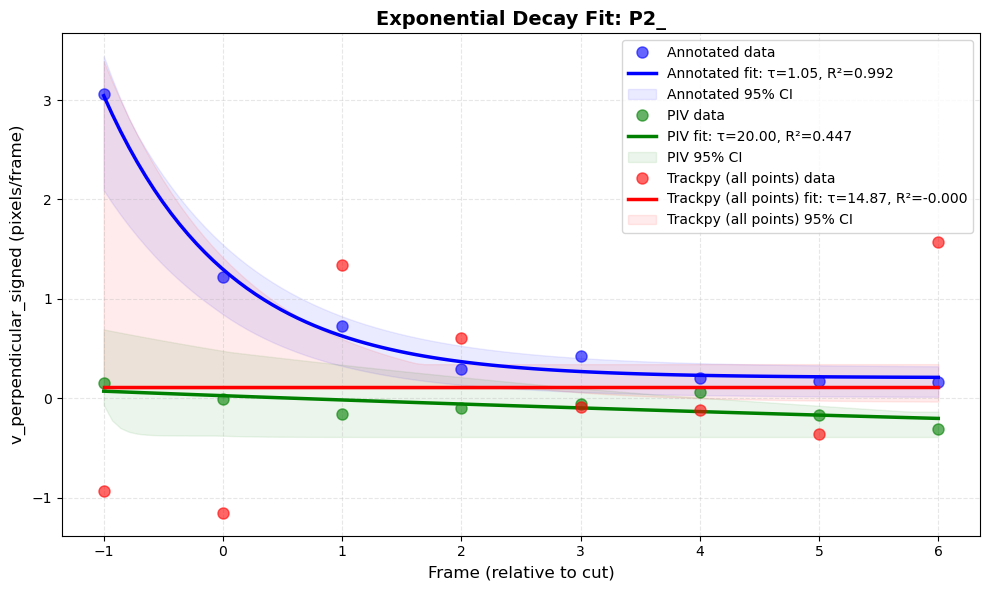

In [25]:
# Fit and plot all datasets
# When per_cell_type=True, separate figures will be created for each cell type
# When per_cell_type=False, a single combined figure will be created

fit_results = fit_and_plot_exponential(
    (annotated_processed, 'Annotated', 'blue'),
    (piv_processed, 'PIV', 'green'),
    (trackpy_processed, 'Trackpy (annotated points)', 'orange'),
    (trackpy_all_processed, 'Trackpy (all points)', 'red'),
    end_offset=6,
    apply_correction=False, 
    n_bootstrap=10,
    per_cell_type=True
)

In [26]:
# Compare results
compare_fit_results(fit_results)


COMPARISON ACROSS TECHNIQUES

CELL TYPE: AB

Technique                      vel                  rate                 tau                 
--------------------------------------------------------------------------------
Annotated                      1.458 ± 0.105     1.066 ± 0.141     0.938 ± 0.140
PIV                            0.154 ± 0.126     0.065 ± 0.323     15.303 ± 8.594
Trackpy (annotated points)     1.283 ± 0.278     0.806 ± 0.679     1.241 ± 7.576
Trackpy (all points)           0.725 ± 0.234     1.599 ± 2.600     0.625 ± 0.347

Ratio                                    vel             rate            tau            
--------------------------------------------------------------------------------
PIV/Annotated                            0.106          0.061          16.320
Trackpy (annotated points)/Annotated     0.880          0.756          1.323
Trackpy (all points)/Annotated           0.497          1.499          0.667
Trackpy (annotated points)/PIV           8.339     